In [14]:
from stage1 import *

In [15]:
nframes,natoms,nmols=(0,0,0)

In [16]:
from stage2 import * 

In [17]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [18]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [19]:
cf=condenseframe(testframe)

In [20]:
cf[591]

array([ 8.03441321e+02, -9.64539095e+01, -1.60332419e+02,  7.91500092e-01,
        2.24175000e+00,  2.16525006e+00])

In [21]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [22]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:01<00:00, 26.95it/s]

30192


In [24]:
print(len(meltframes))

51


In [25]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [26]:
g = get_graph(cf,1,n_neigh,"cry")

In [27]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [28]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 500
batch_size=64
test_train_split = 0.8
model_name = "Interex2.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [29]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:14<00:00, 2126.60it/s]


In [30]:
graphs = graphs_device
total_graphs = len(graphs)


In [31]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 64
number of batches: 471
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [32]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [33]:
from pytorch3d.loss import chamfer_distance

In [34]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
eloss_all=0
floss_all=0
closs_all=0
def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        closs=closs[0]
        closs=torch.tensor(closs,dtype=torch.float32)
        floss= MSE_loss(decoded_x, data.x)
        eloss= MSE_loss(decoded_edge_index.float(), data.edge_index)
        loss=closs+floss+eloss
        loss=loss
        closs_all+=float(closs)
        floss_all+=float(floss)
        eloss_all+=float(eloss)
        loss_all+=float(loss)
        loss.backward()
        # all_loss_mse += float(loss)
        optimizer.step()

    return loss_all / len(train_loader.dataset),closs_all/len(train_loader.dataset), floss_all / len(train_loader.dataset), eloss_all / len(train_loader.dataset)


In [44]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        closs=closs[0]
        closs=torch.tensor(closs,dtype=torch.float32)

        floss = MSE_loss(decoded_x, data.x)
        eloss= MSE_loss(decoded_edge_index.float(), data.edge_index)
        loss=closs+floss+eloss
        loss=loss
        closs_all+=float(closs)
        floss_all+=float(floss)
        eloss_all+=float(eloss)
        loss_all+=float(loss)
        
    return loss_all / len(test_loader.dataset),closs_all/len(test_loader.dataset), floss_all / len(test_loader.dataset), eloss_all / len(test_loader.dataset)


In [45]:
ttrain_losses = []
ttest_losses = []
ctrain_losses = []
ctest_losses = []
etrain_losses = []
etest_losses = []
ftrain_losses = []
ftest_losses = []
if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        ttloss,tcloss,tfloss,teloss = train()
        testtloss,testcloss,testfloss,testeloss = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\Total Loss: {ttloss:.4f},ChamferLoss: {tcloss:.4f},FeatureLoss: {tfloss:.4f},EdgeLoss: {teloss:.4f}')
        print(f'\tTest: \Total Loss: {testtloss:.4f},ChamferLoss: {testcloss:.4f},FeatureLoss: {testfloss:.4f},EdgeLoss: {testeloss:.4f}')

        ttrain_losses.append([ttloss]);
        ttest_losses.append([testtloss]);
        ctrain_losses.append([tcloss]);
        ctest_losses.append([testcloss]);
        ftrain_losses.append([tfloss]);
        ftest_losses.append([testfloss]);
        etrain_losses.append([teloss]);
        etest_losses.append([testeloss]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 4107.0155
	Test: 	MSE Loss: 3393.2059
Epoch: 002
	Train:	MSE Loss: 2682.4423
	Test: 	MSE Loss: 2285.6749
Epoch: 003
	Train:	MSE Loss: 1956.9394
	Test: 	MSE Loss: 1749.3675
Epoch: 004
	Train:	MSE Loss: 1625.6647
	Test: 	MSE Loss: 1428.3017
Epoch: 005
	Train:	MSE Loss: 1496.9149
	Test: 	MSE Loss: 1205.6551
Epoch: 006
	Train:	MSE Loss: 1396.8470
	Test: 	MSE Loss: 1165.9583
Epoch: 007
	Train:	MSE Loss: 1311.5536
	Test: 	MSE Loss: 1077.5139
Epoch: 008
	Train:	MSE Loss: 1241.3780
	Test: 	MSE Loss: 1029.1869
Epoch: 009
	Train:	MSE Loss: 1139.7322
	Test: 	MSE Loss: 957.7307
Epoch: 010
	Train:	MSE Loss: 1096.0486
	Test: 	MSE Loss: 923.3504
Epoch: 011
	Train:	MSE Loss: 1041.3222
	Test: 	MSE Loss: 876.5203
Epoch: 012
	Train:	MSE Loss: 988.4676
	Test: 	MSE Loss: 850.2053
Epoch: 013
	Train:	MSE Loss: 955.7139
	Test: 	MSE Loss: 861.8249
Epoch: 014
	Train:	MSE Loss: 919.9736
	Test: 	MSE Loss: 805.0182
Epoch: 015
	Train:	MSE Loss: 891.0517
	Test: 	MSE Loss: 786.3709
Epoch:

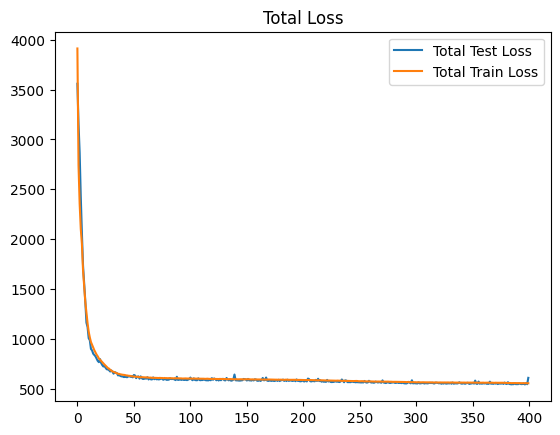

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(ttest_losses, label='Total Test Loss')
    plt.plot(ttrain_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss combined MSE and Chamfer')
    plt.savefig('./plots/'+model_name+'TotalLoss.png')
    plt.show()

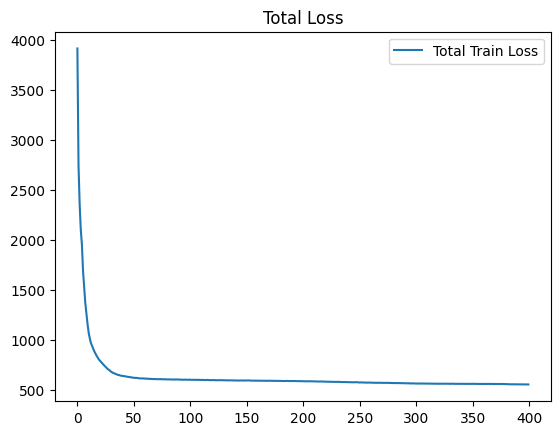

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(ftrain_losses, label='Total Test Loss')
    plt.plot(ftest_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss - MSE')
    plt.savefig('./plots/'+model_name+'MSE.png')
    plt.show()

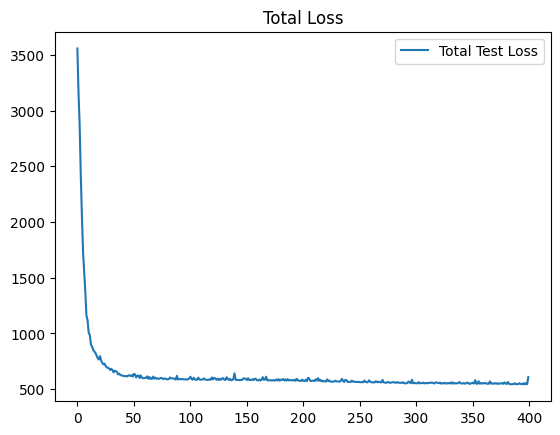

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(ctest_losses, label='Total Test Loss')
    plt.plot(ctrain_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss- Chamfer')
    plt.savefig('./plots/'+model_name+'chamfer.png')
    plt.show()

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(etest_losses, label='Total Test Loss')
    plt.plot(etrain_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss- Edge Loss')
    plt.savefig('./plots/'+model_name+'edge.png')
    plt.show()

In [ ]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


In [ ]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
# len(input_feature[0][heavy_indices])

In [ ]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
